In [1]:
import os
import requests
import re
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


import transformer_lens
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage

/home/c13745859/anaconda3/envs/syntax_probing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# test

In [1]:
class Probe(nn.Module):
  pass

class TwoWordPSDProbe(Probe):
  """ Computes squared L2 distance after projection by a matrix.

  For a batch of sentences, computes all n^2 pairs of distances
  for each sentence in the batch.
  """
  def __init__(self, args):
    print('Constructing TwoWordPSDProbe')
    super(TwoWordPSDProbe, self).__init__()
    self.args = args
    self.probe_rank = args['probe']['maximum_rank']
    self.model_dim = args['model']['hidden_dim']

    # Initialize projection matrix
    self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
    nn.init.uniform_(self.proj, -0.05, 0.05)
    self.to(args['device'])

  def forward(self, batch):
    """ Computes all n^2 pairs of distances after projection
    for each sentence in a batch.

    Note that due to padding, some distances will be non-zero for pads.
    Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j

    Args:
      batch: a batch of word representations of the shape
        (batch_size, max_seq_len, representation_dim)
    Returns:
      A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
    """
    batch = batch.to(self.proj.device) # added

    transformed = torch.matmul(batch, self.proj)
    batchlen, seqlen, rank = transformed.size()
    transformed = transformed.unsqueeze(2)
    transformed = transformed.expand(-1, -1, seqlen, -1)
    transposed = transformed.transpose(1,2).to(self.proj.device)
    diffs = transformed - transposed
    squared_diffs = diffs.pow(2).to(self.proj.device)
    squared_distances = torch.sum(squared_diffs, -1)
    return squared_distances

def get_data():
    sentences_train = []
    sentences_test = []

    root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
    
    files = {
        "test": "en_ewt-ud-test.conllu", 
        "train": "en_ewt-ud-train.conllu"
        }

    for key, file in files.items():
        file_url = os.path.join(root_url, file)
        response = requests.get(file_url)
        response.raise_for_status()


        file_content = StringIO(response.text)
        for sentence in parse_incr(file_content):
            if key == "test":
                sentences_test.append(sentence)
            if key == "train":
                sentences_train.append(sentence)

    # exlude email addresses and URLs
    email_pattern = re.compile(r'\S+@\S+')
    url_pattern = re.compile(r'http\S+|www\S+')

    sentences_train = [s for s in sentences_train if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    sentences_test =  [s for s in sentences_test  if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    
    return sentences_train, sentences_test

class SyntaxProbeDataset(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence.metadata["text"]
            activations = combine_token_embeddings(text, [tok["form"] for tok in sentence], model, layer_name)
            activation = activations.cpu().numpy()
            mat, _, _, _ = distance_matrix_from_sentence(sentence)
                
            if activation.shape[0] > 0 and mat.shape[0] > 0:
                self.sentences.append(sentence)
                self.activations.append(activation)
                self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]
    
def custom_collate_fn(batch):
    """Function to collate a batch of (activation, matrix) tuples by padding them to the same length."""
    # batch: list of (activation, matrix) tuples
    activations, matrices = zip(*batch)
    batch_size = len(activations)
    seq_lens = [a.shape[0] for a in activations]
    max_len = max(seq_lens)
    hidden_dim = activations[0].shape[1]

    # Pad activations
    padded_activations = np.zeros((batch_size, max_len, hidden_dim), dtype=np.float32)
    for i, act in enumerate(activations):
        padded_activations[i, :act.shape[0], :] = act

    # Pad matrices
    padded_matrices = np.full((batch_size, max_len, max_len), fill_value=-1, dtype=np.float32)
    for i, mat in enumerate(matrices):
        l = mat.shape[0]
        padded_matrices[i, :l, :l] = mat

    # Convert to torch tensors
    padded_activations = torch.tensor(padded_activations)
    padded_matrices = torch.tensor(padded_matrices)
    lengths = torch.tensor(seq_lens)

    return padded_activations, padded_matrices, lengths, None

class ProbeRegimen:
  """Basic regimen for training and running inference on probes.
  
  Tutorial help from:
  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

  Attributes:
    optimizer: the optimizer used to train the probe
    scheduler: the scheduler used to set the optimizer base learning rate
  """

  def __init__(self, args):
    self.args = args
    self.max_epochs = args['probe_training']['epochs']
    self.params_path = os.path.join(args['reporting']['root'], args['probe']['params_path'])

  def set_optimizer(self, probe):
    """Sets the optimizer and scheduler for the training regimen.
  
    Args:
      probe: the probe PyTorch model the optimizer should act on.
    """
    self.optimizer = optim.Adam(probe.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1,patience=0)

  def train_until_convergence(self, probe, model, loss, train_dataset, dev_dataset):
    """ Trains a probe until a convergence criterion is met.

    Trains until loss on the development set does not improve by more than epsilon
    for 5 straight epochs.

    Writes parameters of the probe to disk, at the location specified by config.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      loss: An instance of loss.Loss, computing loss between predictions and labels
      train_dataset: a torch.DataLoader object for iterating through training data
      dev_dataset: a torch.DataLoader object for iterating through dev data
    """
    self.set_optimizer(probe)
    min_dev_loss = sys.maxsize
    min_dev_loss_epoch = -1

    self.train_losses = []
    self.val_losses = []
    
    for epoch_index in tqdm(range(self.max_epochs), desc='[training]'):
      epoch_train_loss = 0
      epoch_dev_loss = 0
      epoch_train_epoch_count = 0
      epoch_dev_epoch_count = 0
      epoch_train_loss_count = 0
      epoch_dev_loss_count = 0
      for batch in tqdm(train_dataset, desc='[training batch]'):
        probe.train()
        self.optimizer.zero_grad()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        batch_loss.backward()
        epoch_train_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_train_epoch_count += 1
        epoch_train_loss_count += count.detach().cpu().numpy()
        self.optimizer.step()
      for batch in tqdm(dev_dataset, desc='[dev batch]'):
        self.optimizer.zero_grad()
        probe.eval()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        epoch_dev_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_dev_loss_count += count.detach().cpu().numpy()
        epoch_dev_epoch_count += 1


      # Compute average losses and store them
      avg_train_loss = epoch_train_loss / epoch_train_loss_count
      avg_dev_loss = epoch_dev_loss / epoch_dev_loss_count
      self.train_losses.append(avg_train_loss)
      self.val_losses.append(avg_dev_loss)
        
      self.scheduler.step(epoch_dev_loss)
      tqdm.write('[epoch {}] Train loss: {}, Dev loss: {}'.format(epoch_index, epoch_train_loss/epoch_train_loss_count, epoch_dev_loss/epoch_dev_loss_count))
      if epoch_dev_loss / epoch_dev_loss_count < min_dev_loss - 0.0001:
        torch.save(probe.state_dict(), self.params_path)
        min_dev_loss = epoch_dev_loss / epoch_dev_loss_count
        min_dev_loss_epoch = epoch_index
        tqdm.write('Saving probe parameters')
      elif min_dev_loss_epoch < epoch_index - 4:
        tqdm.write('Early stopping')
        break

  def predict(self, probe, model, dataset):
    """ Runs probe to compute predictions on a dataset.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      dataset: A pytorch.DataLoader object 

    Returns:
      A list of predictions for each batch in the batches yielded by the dataset
    """
    probe.eval()
    predictions_by_batch = []
    for batch in tqdm(dataset, desc='[predicting]'):
      observation_batch, label_batch, length_batch, _ = batch
      word_representations = model(observation_batch)
      predictions = probe(word_representations)
      predictions_by_batch.append(predictions.detach().cpu().numpy())
    return predictions_by_batch

def get_matrices(sentences):
    """function to get distance matrices for a list of sentences"""
    matrices = []
    for sent in sentences:
        mat, _, _, _ = distance_matrix_from_sentence(sent)
        matrices.append(mat)
    return matrices

def combine_token_embeddings(text, word_list, model, layer_name):
    """
    Given a sentence string, a list of words (from UD), and a model,
    returns a tensor of shape (num_words, hidden_dim) where each row
    is the combined embedding for a word (by averaging over subword tokens).
    """
    # Tokenize with offsets
    tokenizer = model.tokenizer
    encoding = tokenizer(text, return_offsets_mapping=True, return_tensors='pt')
    offsets = encoding['offset_mapping'][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    # Get model activations
    _, cache = model.run_with_cache([text])
    activations = cache[layer_name][0]  # shape: (num_tokens, hidden_dim)
    # Map words to token indices
    word_spans = []
    start = 0
    for word in word_list:
        end = start + len(word)
        word_spans.append((start, end))
        start = end + 1  # +1 for space
    # For each word, find token indices whose offsets overlap with the word span
    word_embeddings = []
    for span in word_spans:
        indices = [i for i, (s, e) in enumerate(offsets) if not (e <= span[0] or s >= span[1])]
        if indices:
            emb = activations[indices].mean(dim=0)
        else:
            emb = torch.zeros(activations.shape[1], device=activations.device)
        word_embeddings.append(emb)
    return torch.stack(word_embeddings)

def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms

def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2, plot = True):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    # get adjacency matrix as np array
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist, to get a readable plot
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        nx.draw(
            mst,
            pos=pos,
            ax=ax,
            with_labels=True,
            labels={i: forms[i] for i in range(len(forms))},
            node_color='lightblue',
            edge_color='black',
            node_size=node_size,
            font_size=font_size,
            width=width,
        )
        ax.set_xlabel("ids")
        ax.set_ylabel("root_dist")

    return adj_matrix, ax

NameError: name 'nn' is not defined

In [15]:
from scipy.stats import spearmanr
def eval_parse_trees_by_sentence(test_sentences, predictions, batch_size):
    df = pd.DataFrame(columns=['sentence_length', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'sensitivity', 'specificity', 'spearman_rho'])
    for sentence_idx, sentence in enumerate(test_sentences):
        
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        # ensure square and same size
        pred_mat = pred_mat[:n, :n]
        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices_from(m1, k=1)
        upper_m1 = m1[inds]
        upper_m2 = m2[inds]

        TP = np.count_nonzero((upper_m1 != 0) & (upper_m2 != 0))
        TN = np.count_nonzero((upper_m1 == 0) & (upper_m2 == 0))
        FP = np.count_nonzero((upper_m1 == 0) & (upper_m2 != 0))
        FN = np.count_nonzero((upper_m1 != 0) & (upper_m2 == 0))
    
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 # aka recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 

        inds = np.triu_indices_from(mat, k=1)
        upper_mat = mat[inds]
        upper_pred_mat = pred_mat[inds]

        rho, _ = spearmanr(upper_mat, upper_pred_mat)

        df.loc[sentence_idx] = [n,TP, TN, FP, FN, accuracy, sensitivity, specificity, rho]

    return df

def eval_parse_trees_by_depth(test_sentences, predictions, batch_size):
    total_TP = total_TN = total_FP = total_FN = 0

    df = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])

    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        pred_mat = pred_mat[:n, :n]

        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices(n, k=1)
        for i, j in zip(inds[0], inds[1]):
            lin_dist = abs(i - j) if abs(i - j) < 10 else 10 # bin all values >= 10 together
            if lin_dist not in df.index:
                df.loc[lin_dist] = [0, 0, 0, 0]

            gold_edge = (m1[i, j] != 0)
            pred_edge = (m2[i, j] != 0)

            if gold_edge and pred_edge:
                total_TP += 1
                df.at[lin_dist, 'TP'] += 1
            elif (not gold_edge) and (not pred_edge):
                total_TN += 1
                df.at[lin_dist, 'TN'] += 1
            elif (not gold_edge) and pred_edge:
                total_FP += 1
                df.at[lin_dist, 'FP'] += 1
            elif gold_edge and (not pred_edge):
                total_FN += 1
                df.at[lin_dist, 'FN'] += 1

    # safe per-distance metrics
    df['accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
    df['sensitivity'] = np.where((df['TP'] + df['FN']) > 0, df['TP'] / (df['TP'] + df['FN']), 0)
    df['specificity'] = np.where((df['TN'] + df['FP']) > 0, df['TN'] / (df['TN'] + df['FP']), 0)
    df = df.fillna(0).sort_index()
    return df

class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

In [16]:
# Set up args as in training
layer = 'blocks.8.hook_resid_post'
args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 20},
    'reporting': {'root': './'}
}
# Load probe and parameters
probe_test = TwoWordPSDProbe(args)
state_dict = torch.load(args['probe']['params_path'], map_location=args['device'])
probe_test.load_state_dict(state_dict)
probe_test.eval()

Constructing TwoWordPSDProbe


TwoWordPSDProbe()

In [17]:
_, sentences_test = get_data()

In [26]:
probes = {}
layer_names = [
    'hook_embed',
    'blocks.0.hook_resid_pre',
    'blocks.0.hook_resid_post', 
    'blocks.2.hook_resid_post', 
    'blocks.4.hook_resid_post',
    'blocks.6.hook_resid_post',
    'blocks.8.hook_resid_post',
    'blocks.10.hook_resid_post',
    'blocks.11.hook_resid_post'
]
for layer_name in layer_names:
    print(f'Processing layer: {layer_name}')

    if f'{layer_name}_probe_params.pt' not in os.listdir('probe_params'):
        print(f'No probe parameters found for layer {layer_name}, skipping.')
        continue
    args = {
        'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer_name}_probe_params.pt'},
        'model': {'hidden_dim': 768},
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'probe_training': {'epochs': 20},
        'reporting': {'root': './'}
    }
    # Load probe and parameters
    probe_test = TwoWordPSDProbe(args)
    state_dict = torch.load(args['probe']['params_path'], map_location=args['device'])
    probe_test.load_state_dict(state_dict)
    probe_test.eval()

    # Use IdentityModel as in your code
    class IdentityModel(nn.Module):
        def forward(self, x):
            return x
    model = IdentityModel()
        
    novel_dataset = SyntaxProbeDataset(sentences_test, 'gpt2-small', layer_name)
    novel_dataloader = DataLoader(novel_dataset, batch_size=100, collate_fn=custom_collate_fn)
    
    regimen = ProbeRegimen(args)

    predictions = regimen.predict(probe_test, model=IdentityModel(), dataset=novel_dataloader)

    probes[layer_name] = predictions
    

Processing layer: hook_embed
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 50.85it/s]


Processing layer: blocks.0.hook_resid_pre
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 58.77it/s]


Processing layer: blocks.0.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 35.32it/s]


Processing layer: blocks.2.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 35.40it/s]


Processing layer: blocks.4.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 58.64it/s]


Processing layer: blocks.6.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 45.47it/s]


Processing layer: blocks.8.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 59.59it/s]

Processing layer: blocks.10.hook_resid_post
No probe parameters found for layer blocks.10.hook_resid_post, skipping.
Processing layer: blocks.11.hook_resid_post
No probe parameters found for layer blocks.11.hook_resid_post, skipping.


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'hook_embed'),
  Text(1, 0, 'blocks.0.hook_resid_pre'),
  Text(2, 0, 'blocks.0.hook_resid_post'),
  Text(3, 0, 'blocks.2.hook_resid_post'),
  Text(4, 0, 'blocks.4.hook_resid_post'),
  Text(5, 0, 'blocks.6.hook_resid_post'),
  Text(6, 0, 'blocks.8.hook_resid_post')])

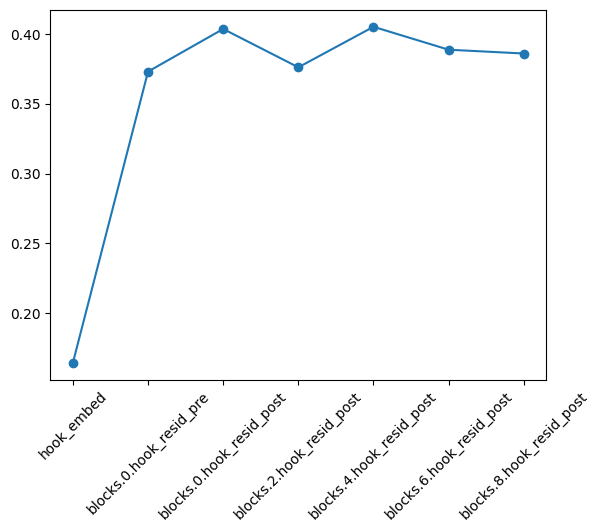

In [28]:
rhos = [eval_parse_trees_by_sentence(test_sentences=sentences_test, predictions=probes[layer_name], batch_size=100).mean().loc['spearman_rho'] for layer_name in layer_names if layer_name in probes.keys()]
rhos
plt.plot(probes.keys(), rhos, marker='o')
plt.xticks(rotation=45)

In [29]:
rhos

[0.16441627233705206,
 0.37324066630070896,
 0.40379155720322096,
 0.3763047822846238,
 0.4053544201622887,
 0.38891789284598116,
 0.3861996098528457]

# new

In [2]:
df_eval = pd.read_pickle('df_acc.pkl')

In [3]:
df_eval

,layer_name,train_loss,val_loss,eval_df_depth,eval_df_sentence
0,hook_embed,"[1.0099025866220135, 0.8898146616989222, 0.866...","[0.9583248350664293, 0.944512085502187, 0.9359...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN ...
1,blocks.0.hook_resid_pre,"[0.8288444233542062, 0.7139407667600419, 0.695...","[0.7575104081364252, 0.7408961962448728, 0.744...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...
2,blocks.0.hook_resid_post,"[8.26981075665423, 0.8066075456156933, 0.73924...","[0.910205113528653, 0.7573759558133644, 0.7344...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...
3,blocks.2.hook_resid_post,"[755.5582550619408, 30.675840401230086, 16.515...","[42.544600402416826, 21.847340175083705, 12.23...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...
4,blocks.4.hook_resid_post,"[1044.724806815864, 49.3754910362388, 25.32737...","[69.70869052838769, 34.29459484163364, 18.3397...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...
5,blocks.6.hook_resid_post,"[1328.1424281806833, 69.61058509506763, 33.727...","[101.38935975129449, 47.372959088769434, 23.89...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...
6,blocks.10.hook_resid_post,"[1287.5217078261994, 72.89346909377939, 23.042...","[130.45059865464043, 38.77567269758071, 13.088...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...
7,blocks.11.hook_resid_post,"[225.0503013535719, 3.6015222612531432, 1.2066...","[10.078529320838268, 1.5380755916628823, 1.061...",TP TN FP FN accuracy sensiti...,sentence_length TP TN FP FN...


In [4]:
for i in range(len(df_eval)):
    print(f"Layer: {df_eval.loc[i, 'layer_name']}")
    print(df_eval.loc[i, 'eval_df_sentence'].mean()[['spearman_rho', 'sensitivity']])

Layer: hook_embed
spearman_rho    0.355399
sensitivity     0.452989
dtype: float64
Layer: blocks.0.hook_resid_pre
spearman_rho    0.544265
sensitivity     0.581349
dtype: float64
Layer: blocks.0.hook_resid_post
spearman_rho    0.582568
sensitivity     0.611273
dtype: float64
Layer: blocks.2.hook_resid_post
spearman_rho    0.528741
sensitivity     0.587563
dtype: float64
Layer: blocks.4.hook_resid_post
spearman_rho    0.492964
sensitivity     0.542346
dtype: float64
Layer: blocks.6.hook_resid_post
spearman_rho    0.610004
sensitivity     0.630752
dtype: float64
Layer: blocks.10.hook_resid_post
spearman_rho    0.555727
sensitivity     0.582714
dtype: float64
Layer: blocks.11.hook_resid_post
spearman_rho    0.605759
sensitivity     0.599420
dtype: float64


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'hook_embed'),
  Text(1, 0, 'blocks.0.hook_resid_pre'),
  Text(2, 0, 'blocks.0.hook_resid_post'),
  Text(3, 0, 'blocks.2.hook_resid_post'),
  Text(4, 0, 'blocks.4.hook_resid_post'),
  Text(5, 0, 'blocks.6.hook_resid_post'),
  Text(6, 0, 'blocks.10.hook_resid_post'),
  Text(7, 0, 'blocks.11.hook_resid_post')])

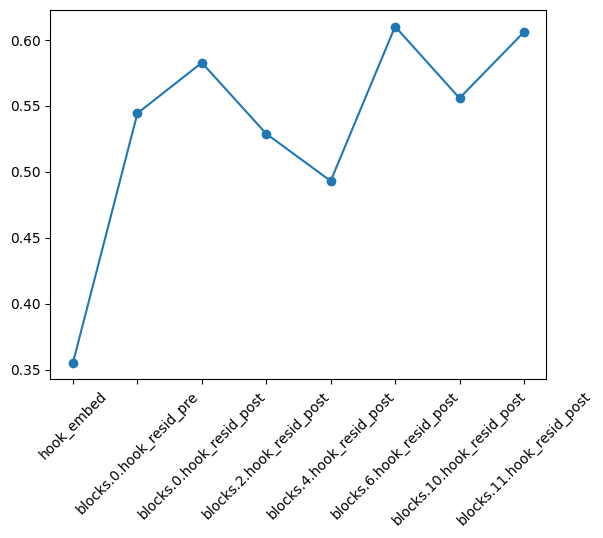

In [6]:
plt.plot(df_eval['layer_name'], df_eval['eval_df_sentence'].apply(lambda x: x['spearman_rho'].mean()), marker='o')
plt.xticks(rotation=45)

/tmp/ipykernel_3655901/630927250.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', num_layers + 1)


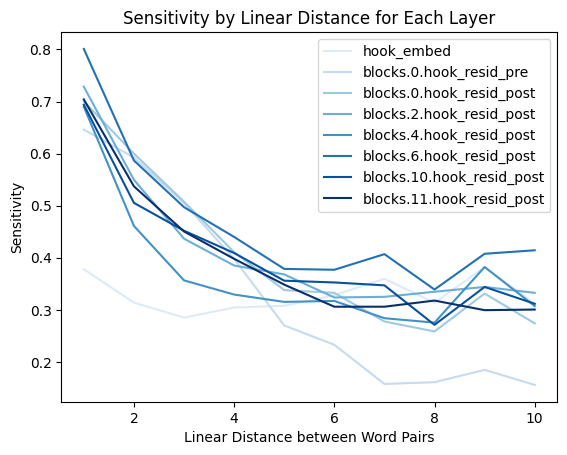

In [5]:
import matplotlib.cm as cm

num_layers = len(df_eval)
cmap = cm.get_cmap('Blues', num_layers + 1)

for i in range(num_layers):
    plt.plot(
        np.arange(1, 1 + len(df_eval.loc[i, "eval_df_depth"]['sensitivity'])),
        df_eval.loc[i, "eval_df_depth"]['sensitivity'],
        color=cmap(i + 1),
        label=df_eval.loc[i, 'layer_name']
    )
plt.xlabel("Linear Distance between Word Pairs")
plt.ylabel("Sensitivity")
plt.title("Sensitivity by Linear Distance for Each Layer")
plt.legend()
plt.show()